In [1]:
import nengo
import nengo_spa as spa
import numpy as np
from random import shuffle
import random


use_ocl = True
if use_ocl:
    import nengo_ocl
    simulator = nengo_ocl.Simulator
else:
    simulator = nengo.Simulator
    
import sys, os

sys.path.append('..')
import experiments as xps

import math
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline
default_cycler = cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'])
plt.rc('axes', prop_cycle=(default_cycler))

from IPython import display


# Model variables

In [2]:
if True: # random seed
    seed = np.random.randint(999)
    print("Warning: setting random seed")
else:
    seed = 1
    
np.random.seed(seed)
random.seed(seed)
s = spa.sym
D = 128*1  # the dimensionality of the vectors
D_GW = 128*2  # the dimensionality of the vectors in GW
GW_THR = .2
AM_THR = .2
AM_function = lambda x: x#x>0
AM_cls = spa.ThresholdingAssocMem # either WTAAssocMem or ThresholdingAssocMem
ROUTING_THR = .25
ROUTING_BIAS = .5
model_source = ["processors","GW"][1]

# Number of neurons (per dimension or ensemble)
scale_npds = 1
npd_AM = int(50*scale_npds) # Default: 50
npd_state = int(50*scale_npds) # Default: 50
npd_BG = int(100*scale_npds) # Default: 100
npd_thal1 = int(50*scale_npds) # Default: 50
npd_thal2 = int(40*scale_npds) # Default: 40
n_scalar = int(50*scale_npds) # Default: 50

n_blocks_per_operation = 10 # default: 10
n_trials_per_digit = 5 # default: 5
n_different_digits = 4 # default: 4
n_different_operations = 3 # default: 3

number_of_total_trials = n_blocks_per_operation * n_trials_per_digit * n_different_digits * n_different_operations
number_of_non_learning_trials = number_of_total_trials
number_of_learning_trials = max(0,number_of_total_trials - number_of_non_learning_trials)
print("number_of_learning_trials",number_of_learning_trials) 
print("number_of_non_learning_trials",number_of_non_learning_trials) 
print("number_of_total_trials",number_of_total_trials)


add_ON = '+ON'
keys = ['TWO','FOUR','SIX','EIGHT','X', \
               'MORE','LESS', \
    'G', 'V', 'COM', 'ADD', 'SUB', \
    'SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB', \
               'ON'
    ] + ['V_COM', 'COM_PM', 'V_ADD', 'V_SUB', 'ADD_COM', 'SUB_COM']

vocab = spa.Vocabulary(dimensions=D, pointer_gen=np.random.RandomState(seed))
vocab_GW = spa.Vocabulary(dimensions=D_GW, pointer_gen=np.random.RandomState(seed))

for voc in [vocab, vocab_GW]:
    voc.populate(";".join(keys))
vocab_GW.populate(";".join([p+"_ON=ON*"+p for p in ['V', 'COM', 'ADD', 'SUB']])) # this is done to avoid similarity with other SPs

trials = xps.createTrials(n_blocks_per_operation, n_trials_per_digit, n_different_digits, n_different_operations, shuffle=True)
xp = xps.Xp1(number_of_learning_trials, trials, fixation="0")
#xp = xps.TestMasking(.083, number_of_learning_trials, trials, fixation="0")

T = number_of_total_trials * xp.trial_length - .00001# simulations run a bit too long
print('T',T)

number_of_learning_trials 0
number_of_non_learning_trials 600
number_of_total_trials 600
T 1217.39999


# Create model

In [3]:
np.random.seed(seed)
random.seed(seed)

model = spa.Network(seed=seed)
with model:
    
    model.config[spa.State].neurons_per_dimension = npd_state
    model.config[spa.Scalar].n_neurons = n_scalar
    model.config[spa.BasalGanglia].n_neurons_per_ensemble = npd_BG
    model.config[spa.Thalamus].neurons_action = npd_thal1
    model.config[spa.Thalamus].neurons_channel_dim = npd_thal1
    model.config[spa.Thalamus].neurons_gate = npd_thal2

    # We start defining the buffer slots in which information can
    # be placed:
    
    # A slot for the goal/task
    G = spa.State(vocab, label='G')
    
    # A slot for the visual input (the digit N). Feedback is used for iconic memory (100-300ms)
    RETINA = spa.WTAAssocMem(
        0.1,
        vocab,
        mapping={k:k+add_ON for k in ['TWO','FOUR','SIX','EIGHT','X']},
        #mapping=['TWO','FOUR','SIX','EIGHT','X'],
        function=lambda x: x>0,
        n_neurons = npd_AM
    )
    nengo.Connection(RETINA.input, RETINA.input, transform=.85, synapse=.005)
    V = spa.State(vocab, label='V')
    nengo.Connection(RETINA.output, V.input, synapse=.055)    
    
    # A slot for the action (MORE or LESS)
    PM = spa.State(vocab, feedback=.8, feedback_synapse=.05, label='PM')
    with nengo.Network() as ACT_net:
        ACT_net.config[nengo.Ensemble].neuron_type = nengo.Direct()
        ACT = spa.State(vocab, label='ACT direct')

    # An associative memory for the + operation
    ADD_input = spa.State(vocab, feedback=.85, feedback_synapse=.05, label='ADD_input')
    ADD = AM_cls(threshold=AM_THR, 
        input_vocab=vocab, mapping=
        {
            'TWO':'FOUR'+add_ON,
            'FOUR':'SIX'+add_ON,
            'SIX':'EIGHT'+add_ON,
            'EIGHT':'TWO'+add_ON,
        },
        function=AM_function,
        label='ADD',
        n_neurons = npd_AM
    )
    ADD_input >> ADD.input
    
    # An associative memory for the - operation
    SUB_input = spa.State(vocab, feedback=.85, feedback_synapse=.05, label='SUB_input')
    SUB = AM_cls(threshold=AM_THR, 
        input_vocab=vocab, mapping=
        {
            'TWO':'EIGHT'+add_ON,
            'FOUR':'TWO'+add_ON,
            'SIX':'FOUR'+add_ON,
            'EIGHT':'SIX'+add_ON,
        },
        function=AM_function,
        label='SUB',
        n_neurons = npd_AM
    )
    SUB_input >> SUB.input
    
    # An associative memory for the "compare to 5" operation
    COM_input = spa.State(vocab, feedback=.85, feedback_synapse=.05, label='COM_input')
    COM = AM_cls(threshold=AM_THR, 
        input_vocab=vocab, mapping=
        {
            'TWO':'LESS'+add_ON,
            'FOUR':'LESS'+add_ON,
            'SIX':'MORE'+add_ON,
            'EIGHT':'MORE'+add_ON,
        },
        function=AM_function,
        label='COM',
        n_neurons = npd_AM
    )
    COM_input >> COM.input

    # A slot that combines selected information from the processors
    GW = spa.State(vocab_GW, label='GW', feedback=.75)
    
    processors = [V, ADD, SUB, COM]
    competition_keys = {
        G: ['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'],
        V: ['TWO','FOUR','SIX','EIGHT','X'],
        ADD: ['TWO','FOUR','SIX','EIGHT'],
        SUB: ['TWO','FOUR','SIX','EIGHT'],
        COM: ['MORE','LESS'],
    }
    preconscious = {}
    filters = {}
    
    for proc in processors:
        
        preconscious[proc] = proc
        
        filters[proc] = spa.modules.WTAAssocMem(
            GW_THR,
            vocab,
            mapping={k:k+add_ON for k in competition_keys[proc]},
            function=lambda x: x>0,
            n_neurons = npd_AM,
            label="filter "+proc.label
        )
        preconscious[proc] >> filters[proc].input
        
        nengo.Connection(filters[proc].output, GW.input, 
            transform=
                     np.dot(
                         vocab_GW.parse(proc.label).get_binding_matrix(), 
                         vocab.transform_to(vocab_GW)
                     ))
    
    conscious_conditions = { # bottom-up strength * top-down attention
        V:   ROUTING_BIAS+spa.dot(preconscious[V]  .output, s.ON) * (1-spa.dot(filters[COM], s.ON)-spa.dot(filters[ADD], s.ON)-spa.dot(filters[SUB], s.ON)),
        ADD: ROUTING_BIAS+spa.dot(preconscious[ADD].output, s.ON) * (1-spa.dot(filters[COM], s.ON)),
        SUB: ROUTING_BIAS+spa.dot(preconscious[SUB].output, s.ON) * (1-spa.dot(filters[COM], s.ON)),
        COM: ROUTING_BIAS+spa.dot(preconscious[COM].output, s.ON)
    }
    access_labels = []
    with spa.Network(label='conscious access') :
        with spa.ActionSelection() as access:
            for proc in processors:
                access_labels.append(proc.label)
                spa.ifmax(proc.label, conscious_conditions[proc],
                            preconscious[proc] >> filters[proc],
                         )
            access_labels.append("Thresholder")
            spa.ifmax(ROUTING_BIAS+ROUTING_THR)
    
    """# Add G to GW
    nengo.Connection(G.output, GW.input, 
            transform=
                         np.dot(
                             vocab_GW.parse(G.label).get_binding_matrix(), 
                             vocab.transform_to(vocab_GW)
                         ))"""
    
                                                                                                         
                                                                                                         
    # Create the inputs
    with spa.Network(label='inputs'):
        RETINA_input = spa.Transcode(xp.RETINA_input,output_vocab = vocab)
        G_input = spa.Transcode(xp.G_input, output_vocab = vocab)

    nengo.Connection(RETINA_input.output, RETINA.input, synapse=None)
    G_input >> G
    
    if model_source == "GW":
        sources = {proc:spa.State(vocab, label='broadcast source '+proc.label) for proc in processors}
        for proc in sources.keys():
            nengo.Connection(GW.output, sources[proc].input, transform=
                             np.dot(
                                 vocab_GW.transform_to(vocab, populate=False),
                                 vocab_GW.parse("~"+proc.label).get_binding_matrix()
                             ))
    elif model_source == "processors":
        sources = {proc:proc if isinstance(proc,spa.State) else proc.output for proc in processors}
    action_labels = []
    with spa.Network(label='broadcast') :
        with spa.ActionSelection() as broadcast:

            action_labels.append("V_COM")
            spa.ifmax("V_COM", ROUTING_BIAS+spa.dot(filters[V], s.ON) * spa.dot(G, s.SIMPLE),
                        sources[V] >> COM_input,
                     )
            
            action_labels.append("V_SUB")
            spa.ifmax("V_SUB", ROUTING_BIAS+spa.dot(filters[V], s.ON) * spa.dot(G, s.CHAINED_SUB),
                        sources[V] >> SUB_input,
                     )

            action_labels.append("V_ADD")
            spa.ifmax("V_ADD", ROUTING_BIAS+spa.dot(filters[V], s.ON) * spa.dot(G, s.CHAINED_ADD),
                        sources[V] >> ADD_input,
                     )

            action_labels.append("ADD_COM")
            spa.ifmax("ADD_COM", ROUTING_BIAS+spa.dot(filters[ADD], s.ON),
                        sources[ADD] >> COM_input,
                     )
               
            action_labels.append("SUB_COM")
            spa.ifmax("SUB_COM", ROUTING_BIAS+spa.dot(filters[SUB], s.ON),
                        sources[SUB] >> COM_input,
                     )
                
            action_labels.append("COM_PM")
            spa.ifmax("COM_PM", ROUTING_BIAS+spa.dot(filters[COM], s.ON),
                        sources[COM] >> PM,
                     )            
            
            action_labels.append("Thresholder")
            spa.ifmax("Thresholder", ROUTING_BIAS+ROUTING_THR) # Threshold for action
    
    
    with spa.Network(label='Action'):
        with spa.ActionSelection():            
                spa.ifmax( spa.dot(PM, s.MORE),
                            s.MORE >> ACT)
                spa.ifmax( spa.dot(PM, s.LESS),
                            s.LESS >> ACT)

                spa.ifmax( .3)
            
    BTN = nengo.Node(xps.Button([vocab.parse('MORE').v, vocab.parse('LESS').v], xp.trial_length), size_in=D)
    nengo.Connection(ACT.output, BTN)

# Set up some probes

In [4]:
with model:
    
    probe_dt = .05
    probe_synapse = .015
#     p_V = nengo.Probe(V.output, synapse = probe_synapse)#, sample_every = probe_dt)
#     p_G = nengo.Probe(G.output, synapse = probe_synapse)#, sample_every = probe_dt)

#     p_GW = nengo.Probe(GW.output, synapse = probe_synapse)#, sample_every = probe_dt)

#     p_ADD = nengo.Probe(ADD.output, synapse = probe_synapse)#, sample_every = probe_dt)
#     p_SUB = nengo.Probe(SUB.output, synapse = probe_synapse)#, sample_every = probe_dt)
#     p_COM = nengo.Probe(COM.output, synapse = probe_synapse)#, sample_every = probe_dt)
    
#     p_PM = nengo.Probe(PM.output, synapse = probe_synapse)#, sample_every = probe_dt)
#     p_ACT = nengo.Probe(ACT.output, synapse = probe_synapse)#, sample_every = probe_dt)
    p_BTN = nengo.Probe(BTN)#, sample_every = probe_dt)
    
#     p_broadcast_in = nengo.Probe(broadcast.bg.input, synapse = probe_synapse)
#     p_broadcast_out = nengo.Probe(broadcast.bg.output, synapse = probe_synapse)
#     p_access_in = nengo.Probe(access.bg.input, synapse = probe_synapse)
#     p_access_out = nengo.Probe(access.bg.output, synapse = probe_synapse)


# Run the model

In [5]:
dt = .001
print("Number of neurons:", model.n_neurons)
print("T:",T)
with simulator(model, dt = dt, seed=seed) as sim:
    sim.run(T)

Number of neurons: 158650
T: 1217.39999
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

# Plot results

In [6]:
if False:
    
    def plot_similarities(t_range, data, vocab, keys=False, autoscale=False, title='Similarity', sort_legend=True, permutation=None, subplot_nrows=0, subplot_ncols=0, subplot_i = 1):

        if not keys:
            keys = list(vocab.keys())

        if subplot_nrows * subplot_ncols > 0:
            plt.subplot(subplot_nrows,subplot_ncols,subplot_i)

        if permutation is None:
            permutation = range(vocab.dimensions)
        vectors = np.array([vocab.parse(p).v @ np.identity(vocab.dimensions)[permutation] for p in keys])
        mean_activation = spa.similarity(data, vectors).mean(axis=0)
        sort_idx = np.argsort(mean_activation)[::-1]    

        ymin, ymax = -1.5, 1.5
        plt.ylim(ymin, ymax)
        plt.autoscale(autoscale, axis='y')
        plt.grid(True)
        plt.plot(t_range, spa.similarity(data, vectors[sort_idx]), linewidth=2.5)
        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Similarity")
        plt.xlim(left=t_range[0], right=t_range[-1])
        plt.xticks(np.arange(t_range[0], t_range[-1], xp.trial_length))
        leg = plt.legend([str(round(mean_activation[sort_idx][i],2))+' '+k for i,k in enumerate(np.array(keys)[sort_idx])], loc='upper center',
                   bbox_to_anchor=(0.5, -0.13), ncol=3)
        
        # set the linewidth of each legend object
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
            
        if subplot_nrows * subplot_ncols == 0:
            plt.show()

        return subplot_i + 1



    subplot_nrows=9
    subplot_ncols=1
    plt.figure(figsize=(6*subplot_ncols,4.5*subplot_nrows))
    
    def trial_t(trial_number):
        return trial_number*xp.trial_length
    
    start = trial_t(0)
    end = trial_t(4)
    skip = 5
    trange = sim.trange()
    selected_idx = np.where(np.logical_and(trange > start, trange < end))
    trange = trange[selected_idx][::skip]


    subplot_i=plot_similarities(trange, sim.data[p_V][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT', 'ON','X'], title='V', subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_G][selected_idx][::skip], vocab, keys=['SIMPLE','CHAINED_SUB','CHAINED_ADD'], title='G', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ADD][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','ON','X'], title='ADD', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_SUB][selected_idx][::skip], vocab, keys=['TWO','FOUR','SIX','EIGHT','ON','X'], title='SUB', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_COM][selected_idx][::skip], vocab, keys=['MORE','LESS','ON'], title='COM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_PM][selected_idx][::skip], vocab, keys=['MORE','LESS','ON'], title='PM', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_ACT][selected_idx][::skip], vocab, keys=['MORE','LESS','ON'], title='ACT', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)
    subplot_i=plot_similarities(trange, sim.data[p_GW][selected_idx][::skip], vocab_GW, keys=[p+"*ON" for p in ["G", "V", "ADD", "SUB", "COM"]], title='GW', subplot_i=subplot_i, subplot_nrows=subplot_nrows, subplot_ncols=subplot_ncols)

    trange = sim.trange()[selected_idx]
    plt.subplot(subplot_nrows,subplot_ncols,subplot_i)
    plt.plot(trange, sim.data[p_BTN][selected_idx], color='black', linewidth=3.5)
    plt.xlim(left=trange[0], right=trange[-1])
    plt.xticks(np.arange(trange[0], trange[-1], xp.trial_length))
    plt.ylim(-.2,2.2)
    plt.ylabel("Action")
    plt.grid(True)
    
    plt.tight_layout()

    plt.show()
    
    


NameError: name 'selected_idx' is not defined

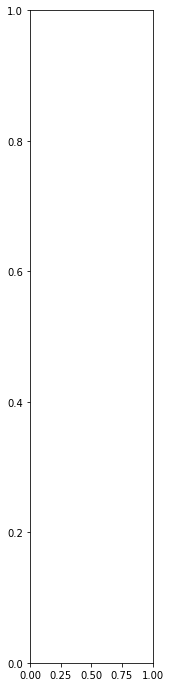

In [7]:
plt.figure(figsize=(18,12))
for i in range(broadcast.bg.input.size_out):
    plt.subplot(1,broadcast.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_broadcast_in][:,i][selected_idx][::skip])
    plt.title(action_labels[i])
    plt.ylim(-.5,1)

plt.show()

plt.figure(figsize=(18,12))
for i in range(broadcast.bg.input.size_out):
    plt.subplot(1,broadcast.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_broadcast_out][:,i][selected_idx][::skip])
    plt.title(action_labels[i])
    plt.ylim(-1.5,.5)

plt.show()

In [ ]:
plt.figure(figsize=(18,12))
for i in range(access.bg.input.size_out):
    plt.subplot(1,access.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_access_in][:,i][selected_idx][::skip])
    plt.title(access_labels[i])
    plt.ylim(-.5,1)

plt.show()

plt.figure(figsize=(18,12))
for i in range(access.bg.input.size_out):
    plt.subplot(1,access.bg.input.size_out,i+1)
    plt.plot(sim.trange()[selected_idx][::skip], sim.data[p_access_out][:,i][selected_idx][::skip])
    plt.title(access_labels[i])
    plt.ylim(-1.5,.5)

plt.show()

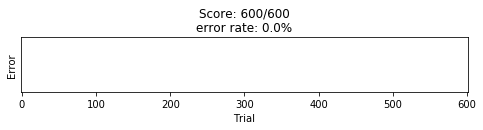

In [8]:
digit_key_to_int = {'TWO':2, 'FOUR':4, 'SIX':6, 'EIGHT':8}
digit_key_to_idx = {k:i for i,k in enumerate(digit_key_to_int.keys())}
operations_key_to_idx = {k:i for i,k in enumerate(['SIMPLE', 'CHAINED_ADD', 'CHAINED_SUB'])}

n_per_condition = n_blocks_per_operation * n_trials_per_digit

RTs = np.zeros((n_different_operations, n_different_digits, n_per_condition)) 
performance = np.zeros((n_different_operations, n_different_digits, n_per_condition)) # 0:no answer / 1:wrong answer / 2:correct answer
xp_errors = []

indices = np.zeros((n_different_operations, n_different_digits), dtype=int) 


def get_expected_action(trial):
    N = digit_key_to_int[trial.stimulus] 
    if trial.operation == 'CHAINED_ADD':
        N += 2
    elif trial.operation == 'CHAINED_SUB':
        N -= 2
    if N > 8:
        N = 2
    elif N < 2:
        N = 8
    expected_action = 1 + int(not N > 5)
    return expected_action

t = 0
while t<T-.01:
    t += xp.trial_length
    trial = xp(t)[0]
    expected_action = get_expected_action(trial)
    t_window = (np.where(np.logical_and(sim.trange() < t, sim.trange() > t-xp.trial_length))[0],)
    
    # get model's action
    model_behaviour = sim.data[p_BTN][t_window]
    if np.count_nonzero(model_behaviour) > 1:
        raise ValueError("more than one action")
    
    
    cond_idx = (operations_key_to_idx[trial.operation], digit_key_to_idx[trial.stimulus])
    trial_idx = indices[cond_idx]
    
    model_action = model_behaviour.sum()
    if model_action == 0:
        trial_RT = 0
        trial_performance = 0
    else:
        action_t_idx = np.nonzero(model_behaviour[:,0])
        trial_RT = sim.trange()[t_window][action_t_idx][0] - (t-xp.trial_length) - xp.t_start
        trial_performance = int(model_action==expected_action) + 1
    
    xp_errors += [trial_performance!=2]
    
    performance[cond_idx+(trial_idx,)] = trial_performance
    RTs[cond_idx+(trial_idx,)] = trial_RT
    
    indices[cond_idx] += 1 # increment index of this condition
    


xp_errors = np.array(xp_errors, dtype=bool)

plt.figure(figsize=(8,1))
plt.eventplot(np.where(xp_errors), color='black')
plt.yticks([])
plt.ylabel('Error')
plt.xlim(-1,len(xp_errors)+1)
plt.title('Score: '+str(number_of_total_trials-xp_errors.sum())+'/'+str(number_of_total_trials)+"\n"+
         "error rate: "+str(round(100*xp_errors.sum()/number_of_total_trials,2))+"%")
plt.xlabel('Trial')
plt.show()




In [ ]:
# print(indices)
# print(RTs)
print(performance.shape)
print(performance[2,1,:])

## Simple blocks plot

In [ ]:
RTs_simple = np.copy(RTs[0,:,:]) * 1000
RTs_simple = [RTs_simple[i,:] for i in range(n_different_digits)]
print(RTs_simple)
for digit_RTs in RTs_simple:
#     print(digit_RTs.shape)
    digit_RTs = digit_RTs[digit_RTs != 0] # remove outliers (no answer)
#     print(digit_RTs.shape)
#     print('\n')

RTs_simple_median = np.array([np.median(digit_RTs) for digit_RTs in RTs_simple])
RTs_simple_std = np.array([digit_RTs.std() for digit_RTs in RTs_simple])
plt.errorbar([2,4,6,8][:n_different_digits], RTs_simple_median, yerr=RTs_simple_std, color='black', capsize=3, capthick=2, marker='.', markersize=12, markerfacecolor='white')
plt.ylabel('Median Reaction times (ms)')
plt.xlabel('Stimuli')
plt.xticks([2,4,6,8][:n_different_digits])
plt.show()

print(RTs_simple_median)




for unresponsive_as_error in [False,True]:

    if unresponsive_as_error:
        performance_simple = np.copy(performance[0,:,:])
        err_simple = np.sum(performance_simple != 2, axis=1) / n_per_condition * 100
        plt.title('Errors and absence of response')
        
    else:
        performance_simple = np.copy(performance[0,:,:])
        n_responsive = np.sum(performance_simple!=0) # count the number of responses
        err_simple = np.sum(performance_simple == 1, axis=1) / n_responsive * 100
        plt.title('Errors')

    plt.bar([2,4,6,8][:n_different_digits], err_simple, color='black')
    plt.ylabel('Error rates (%)')
    plt.xlabel('Stimuli')
    plt.xticks([2,4,6,8][:n_different_digits])
    plt.ylim(bottom=0)
    plt.show()
        

## Chained blocks plot

In [ ]:
np.mean([])